# 비트코인 시세 예측하기

In [8]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# <Step1. 탐색> : 시간정보가 포함된 데이터 살펴보기

### [market price 데이터셋의 기본 정보]

In [9]:
# Data Source : https://www.blockchain.com/ko/charts/market-price?timespan=60days

file_path = '../data/market-price.csv'
bitcoin_df = pd.read_csv(file_path, names = ['day', 'price'])

In [10]:
# 기본 정보를 출력합니다.
print(bitcoin_df.shape)
print(bitcoin_df.info())

(365, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   day     365 non-null    object 
 1   price   365 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB
None


In [11]:
bitcoin_df.tail()

,day,price
360,2018-08-22 00:00:00,6575.229167
361,2018-08-23 00:00:00,6434.881667
362,2018-08-24 00:00:00,6543.645714
363,2018-08-25 00:00:00,6719.429231
364,2018-08-26 00:00:00,6673.274167


### [시계열 데이터 살펴보기]

In [12]:
# to_datetime으로 day 피처를 시계열 피처로 변환합니다. 
bitcoin_df['day'] = pd.to_datetime(bitcoin_df['day'])

# day 데이터프레임의 index로 설정합니다.
bitcoin_df.index = bitcoin_df['day']
bitcoin_df.set_index('day', inplace=True)
bitcoin_df.head()

,price
day,
2017-08-27,4354.308333
2017-08-28,4391.673517
2017-08-29,4607.985450
2017-08-30,4594.987850
2017-08-31,4748.255000


In [13]:
bitcoin_df.describe()

,price
count,365.000000
mean,8395.863578
std,3239.804756
min,3319.630000
25%,6396.772500
50%,7685.633333
75%,9630.136277
max,19498.683333


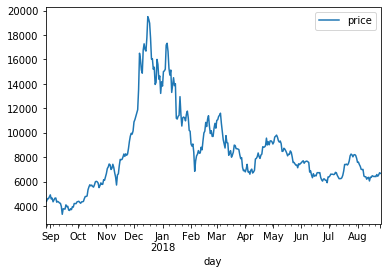

In [14]:
# 일자별 비트코인 시세를 시각화합니다.
bitcoin_df.plot()
plt.show()

# <Step2. 예측> : 파이썬 라이브러리를 활용한 시세 예측

### [ARIMA 모델 활용하기]

###### ARIMA 모델 학습

In [15]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

# (AR=2, 차분=1, MA=2) 파라미터로 ARIMA 모델을 학습합니다.
model = ARIMA(bitcoin_df.price.values, order=(2,1,2))
model_fit = model.fit(trend='c', full_output=True, disp=True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  364
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2787.553
Method:                       css-mle   S.D. of innovations            512.415
Date:                Fri, 29 May 2020   AIC                           5587.107
Time:                        23:11:45   BIC                           5610.490
Sample:                             1   HQIC                          5596.400
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3603     27.794      0.229      0.819     -48.115      60.836
ar.L1.D.y     -0.3786      1.823     -0.208      0.836      -3.952       3.195
ar.L2.D.y      0.1587      1.189      0.134      0.8

###### 모델의 성능 & 예측 결과 시각화
- 학습한 모델이 학습 데이터에 대해서 예측한 결과만을 시각화합니다.

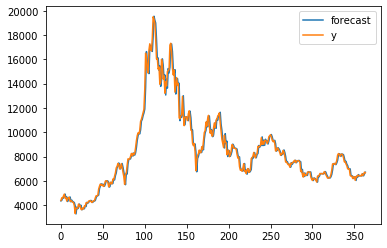

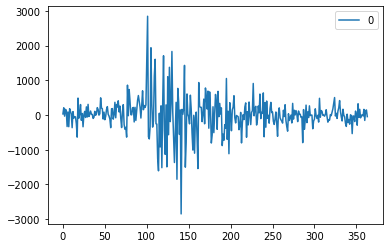

In [16]:
fig = model_fit.plot_predict() # 학습 데이터에 대한 예측 결과입니다. (첫번째 그래프)
residuals = pd.DataFrame(model_fit.resid) # 잔차의 변동을 시각화합니다. (두번째 그래프)
residuals.plot()

###### 실제 데이터와의 비교
- 예측 결과인 마지막 5일의 예측값을 실제 데이터와 비교해봅니다.

In [17]:
forecast_data = model_fit.forecast(steps=5) # 학습 데이터셋으로부터 5일 뒤를 예측합니다.

# 테스트 데이터셋을 불러옵니다.
test_file_path = '../data/market-price-test.csv'
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds', 'y'])

pred_y = forecast_data[0].tolist() # 마지막 5일의 예측 데이터입니다. (2018-08-27 ~ 2018-08-31)
test_y = bitcoin_test_df.y.values # 실제 5일 가격 데이터입니다. (2018-08-27 ~ 2018-08-31)
pred_y_lower = [] # 마지막 5일의 예측 데이터의 최소값입니다.
pred_y_upper = [] # 마지막 5일의 예측 데이터의 최대값입니다.
for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)

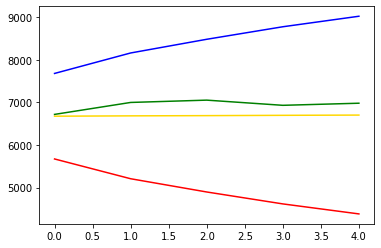

In [18]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최소가격 그래프입니다.
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최대가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

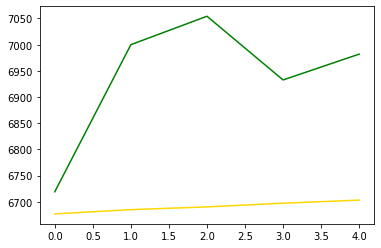

In [19]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

In [20]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

# test 데이터의 RMSE 점수

270.7291799570037


### [Facebook Prophet 활용하기]

- 아래 코드 실행을 위해, anaconda prompt 혹은 Terminal에서 아래와 같은 패키지들을 설치해 줍니다.
    - (env_name) `conda install -c conda-forge fbprophet`
- prophet의 input data columns는 'ds'와 'y'로 고정되어야 합니다.
- seasonality_mode : 연간, 월간, 주간, 일간 등의 트렌드성을 반영하는 것을 의미합니다. 비트코인 데이터의 경우 대부분의 주기마다 트렌드성이 반영되는 것이 좋습니다.
- changepoint_prior_scale : 트렌드가 변경되는 문맥을 반영하여 예측합니다. 수치가 높을수록 overfitting에 가까워집니다.

###### Prophet 모델 학습

In [21]:
conda update -n base -c defaults conda

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Admin\anaconda3

  added / updated specs:
    - conda


The following packages will be REMOVED:

  python_abi-3.7-1_cp37m

The following packages will be SUPERSEDED by a higher-priority channel:

  conda              conda-forge::conda-4.8.3-py37hc8dfbb8~ --> pkgs/main::conda-4.8.3-py37_0


Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [22]:
conda install -c conda-forge fbprophet

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Admin\anaconda3

  added / updated specs:
    - fbprophet


The following NEW packages will be INSTALLED:

  python_abi         conda-forge/win-64::python_abi-3.7-1_cp37m

The following packages will be UPDATED:

  conda                       pkgs/main::conda-4.8.3-py37_0 --> conda-forge::conda-4.8.3-py37hc8dfbb8_1


Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [23]:
from fbprophet import Prophet

In [24]:
# prophet을 사용하기 위해서는 다음과 같이 피처의 이름을 변경해야 합니다 : 'ds', 'y'
bitcoin_df = pd.read_csv(file_path, names=['ds', 'y'])
prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

###### 모델로부터 예측할 기간을 정의하고, 결과를 도출

In [25]:
# 5일을 내다보며 예측합니다.
future_data = prophet.make_future_dataframe(periods=5, freq='d')
forecast_data = prophet.predict(future_data)

In [26]:
forecast_data.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
365,2018-08-27,710.869218,6189.189636,7571.376604,710.869218,710.869218,9.795516,9.795516,9.795516,8.681537,...,-0.008579,-0.008579,-0.008579,-1.105399,-1.105399,-1.105399,0.0,0.0,0.0,6882.306915
366,2018-08-28,714.864451,6329.369687,7678.666530,714.864451,714.864451,9.795516,9.795516,9.795516,8.758497,...,0.021390,0.021390,0.021390,-1.058409,-1.058409,-1.058409,0.0,0.0,0.0,6976.002532
367,2018-08-29,718.859685,6310.846205,7699.144587,718.859685,718.859685,9.795516,9.795516,9.795516,8.718816,...,-0.050000,-0.050000,-0.050000,-1.026699,-1.026699,-1.026699,0.0,0.0,0.0,6986.465207
368,2018-08-30,722.854919,6352.456849,7796.413205,717.280347,725.750032,9.795516,9.795516,9.795516,8.760568,...,-0.021787,-0.021787,-0.021787,-1.013160,-1.013160,-1.013160,0.0,0.0,0.0,7055.474837
369,2018-08-31,726.850153,6381.241691,7888.422188,712.215812,741.321577,9.795516,9.795516,9.795516,8.814185,...,0.038756,0.038756,0.038756,-1.020087,-1.020087,-1.020087,0.0,0.0,0.0,7133.441748


In [27]:
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
365,2018-08-27,6882.306915,6189.189636,7571.376604
366,2018-08-28,6976.002532,6329.369687,7678.666530
367,2018-08-29,6986.465207,6310.846205,7699.144587
368,2018-08-30,7055.474837,6352.456849,7796.413205
369,2018-08-31,7133.441748,6381.241691,7888.422188


###### 결과의 시각화

- 전체 데이터를 기반으로 학습한, 5일 단위의 예측 결과를 시각화합니다.

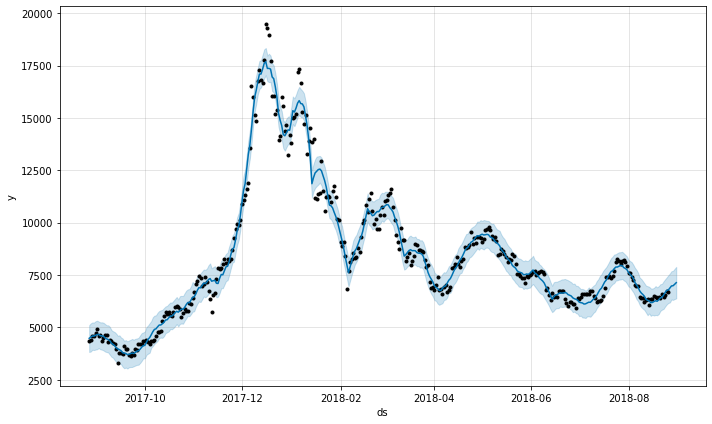

In [28]:
fig1 = prophet.plot(forecast_data)

- seasonality_mode로 설정했었던 기간별 트렌드 정보를 시각화합니다.

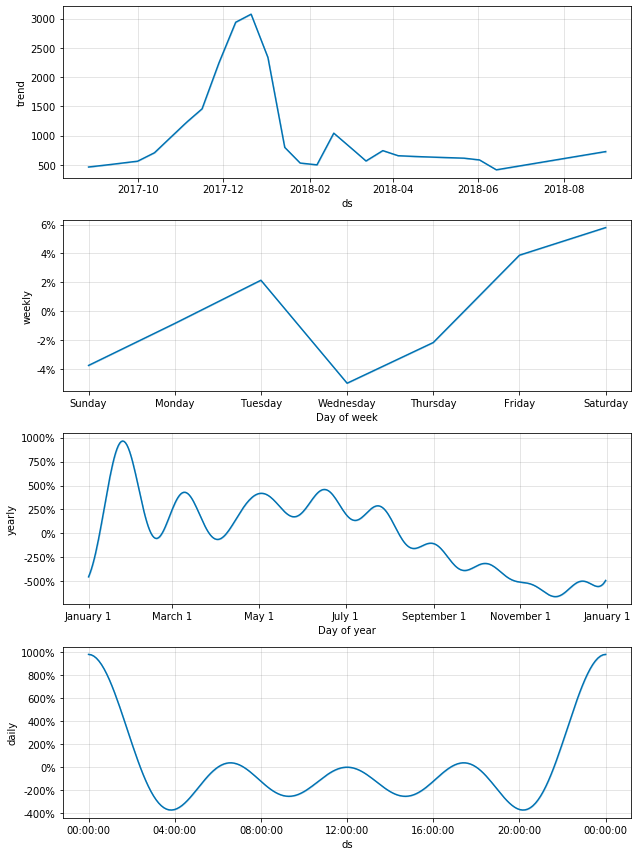

In [29]:
fig2 = prophet.plot_components(forecast_data)

###### 모델의 성능
- 실제 가격과 예측한 가격간의 차이 : 첫 5일과 마지막 5일은 제외하고 계산합니다.
- train RMSE 점수 : 521.5
- train r2 점수 (train 데이터에 대한 모델의 설명력) : 0.97

In [30]:
y = bitcoin_df.y.values[5:] # 첫 5일을 제외한 실제 가격 데이터입니다.
y_pred = forecast_data.yhat.values[5:-5] # 첫 5일, 마지막 5일을 제외한 예측 가격 데이터입니다.

In [31]:
rmse = sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)
print(rmse)
print(r2)

519.4229203587638
0.9740657504711117


###### 실제 데이터와의 비교
- 예측 결과인 마지막 5일의 예측값을 실제 데이터와 비교해봅니다.

In [32]:
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds', 'y'])

pred_y = forecast_data.yhat.values[-5:] # 마지막 5일의 예측 데이터입니다. (2018-08-27 ~ 2018-08-31)
test_y = bitcoin_test_df.y.values # 실제 5일 가격 데이터입니다. (2018-08-27 ~ 2018-08-31)
pred_y_lower = forecast_data.yhat_lower.values[-5:] # 마지막 5일의 예측 데이터의 최소값입니다.
pred_y_upper = forecast_data.yhat_upper.values[-5:] # 마지막 5일의 예측 데이터의 최대값입니다.

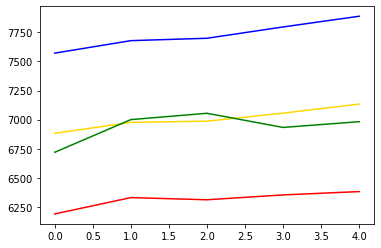

In [33]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최소가격 그래프입니다.
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최대가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

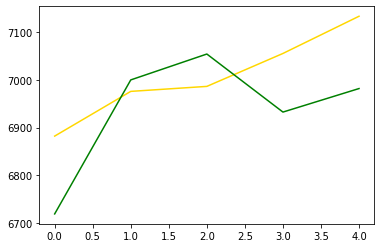

In [34]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

In [43]:
# RMSE 점수

rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

933.6503856863973


# <Step3. 활용> : 더 나은 결과를 위한 방법들

### [상한가 및 하한가 선정]

- 주가데이터의 경우 의미가 없지만, 일반적인 시계열 데이터의 경우 상한값 혹은 하한값을 잘 설정해주는 것이 도움이 되기도 합니다.

In [44]:
bitcoin_df = pd.read_csv(file_path, names=['ds', 'y'])

# 상한가를 설정합니다.
bitcoin_df['cap'] = 20000

# 상한가 적용을 위한 파라미터를 다음과 같이 설정합니다.
prophet = Prophet(seasonality_mode='multiplicative', 
                  growth='logistic',
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

In [45]:
# 5일을 내다보며 예측합니다.
future_data = prophet.make_future_dataframe(periods=5, freq='d')

# 상한가를 설정합니다.
future_data['cap'] = 20000
forecast_data = prophet.predict(future_data)

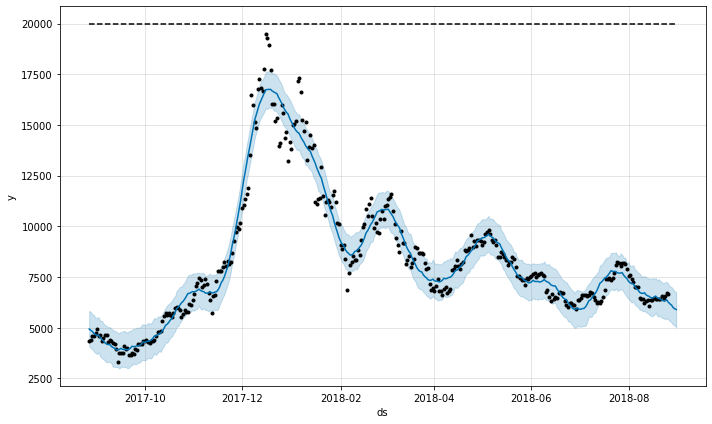

In [46]:
fig = prophet.plot(forecast_data)

###### 실제 데이터와의 비교
- 비트코인 데이터의 경우, 상한선을 둠으로써 오히려 예측력이 다소 떨어지는 결과를 보였습니다.

In [47]:
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds', 'y'])

# 모델이 예상한 마지막 5일의 가격 데이터를 가져옵니다.
pred_y = forecast_data.yhat.values[-5:]
test_y = bitcoin_test_df.y.values
pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

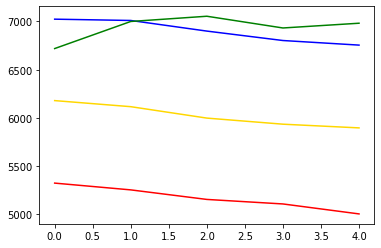

In [48]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최소가격 그래프입니다.
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최대가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

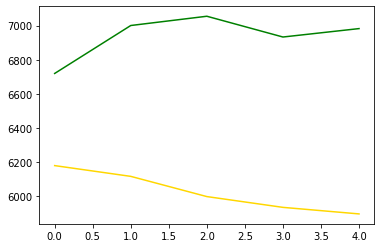

In [49]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

In [50]:
rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

933.6503856863973


### [이상치 제거하기]

- 가격이 18000을 넘어가는 값을 이상치로 판단하여 제거합니다.

In [52]:
# 18000 이상의 데이터는 이상치라고 판단
bitcoin_df = pd.read_csv(file_path, names=['ds', 'y'])
bitcoin_df.loc[bitcoin_df['y'] > 18000, 'y'] = None

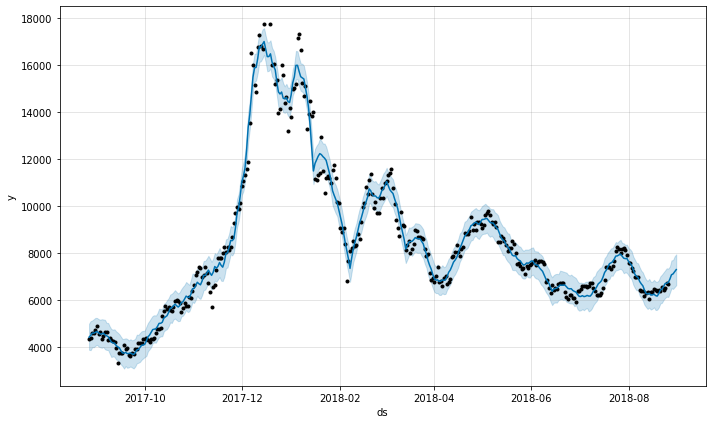

In [53]:
# prophet 모델을 학습합니다.
prophet = Prophet(seasonality_mode='multiplicative',
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

# 5일단위의 미래를 예측합니다.
future_data = prophet.make_future_dataframe(periods=5, freq='d')
forecast_data = prophet.predict(future_data)

# 예측 결과를 그래프로 출력합니다.
fig = prophet.plot(forecast_data)

###### 실제 데이터와의 비교
- 비트코인 데이터의 경우, 이상치를 제거함으로써 오히려 예측력이 다소 떨어지는 결과를 보였습니다.
- 모델의 정확도 스코어 측면에서는 떨어졌지만, 트렌드 예측의 측면에서는 다소 나은 모습을 보여줄 수도 있습니다.

In [54]:
bitcoin_test_df = pd.read_csv(test_file_path, names = ['ds', 'y'])

# 모델이 예상한 마지막 5일의 가격 데이터를 가져옵니다.
pred_y = forecast_data.yhat.values[-5:]
test_y = bitcoin_test_df.y.values
pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

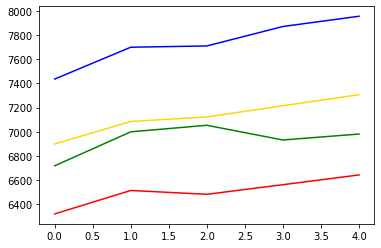

In [55]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최소가격 그래프입니다.
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최대가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

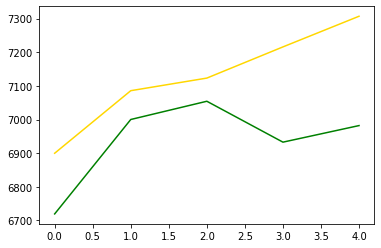

In [56]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

In [57]:
# 테스트 데이터의 RMSE를 출력합니다.
rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

214.7340224079163


# 재미로 알아보는 내일의 비트코인 시세

###### 좋은 예측력을 보였던 Prophet 모델로 향후 5일간의 비트코인 시세를 예측해 봅시다.

In [58]:
# prophet을 사용하기 위해서는 다음과 같이 피처의 이름을 변경해야 합니다 : 'ds', 'y'
bitcoin_df = pd.read_csv(file_path, names = ['ds', 'y'])
prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

In [59]:
# 5일단위의 미래를 예측합니다.
future_data = prophet.make_future_dataframe(periods=5, freq = 'd')
forecast_data = prophet.predict(future_data)

In [60]:
# 테스트 데이터를 불러옵니다.
bitcoin_test_df = pd.read_csv(test_file_path, names = ['ds', 'y'])

# 마지막 5일의 데이터를 가져옵니다.
pred_y = forecast_data.yhat.values[-5:]
test_y = bitcoin_test_df.y.values
pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

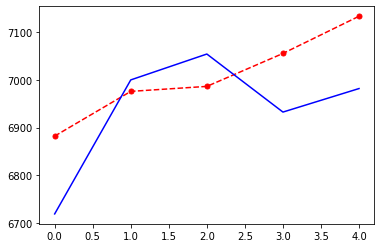

In [61]:
plt.plot(pred_y, color="red", ls="--", marker="o", ms=5) # 모델이 예상한 가격 그래프입니다.
plt.plot(test_y, color="blue") # 실제 가격 그래프입니다.